In [1]:
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf
# !pip install tslearn

In [172]:
import os
import math
import pandas as pd
import numpy as np
import folium
import warnings
warnings.filterwarnings(action='ignore')
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic') 
plt.rcParams['axes.unicode_minus'] = False
# from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# Algorithms
# from minisom import MiniSom
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA

In [3]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


# 데이터 준비

In [4]:
path = '/content/gdrive/My Drive/airdata/'
data = pd.read_csv(path+'2015-2020.csv')
data.drop(data.columns[0],inplace=True,axis=1)
data

,지역,측정소코드,측정소명,측정일시,SO2,CO,O3,NO2,PM10,PM25,주소,망
0,강원 강릉시,632132,옥천동,2015040101,0.0030,0.5,0.052,0.0050,57.0,41.0,강원 강릉시 옥천동 327-2(옥천동주민센터),NaN
1,강원 강릉시,632132,옥천동,2015040102,0.0030,0.5,0.060,0.0040,56.0,43.0,강원 강릉시 옥천동 327-2(옥천동주민센터),NaN
2,강원 강릉시,632132,옥천동,2015040103,0.0030,0.5,0.057,0.0040,72.0,54.0,강원 강릉시 옥천동 327-2(옥천동주민센터),NaN
3,강원 강릉시,632132,옥천동,2015040104,0.0030,0.5,0.049,0.0040,80.0,48.0,강원 강릉시 옥천동 327-2(옥천동주민센터),NaN
4,강원 강릉시,632132,옥천동,2015040105,0.0030,0.5,0.045,0.0040,62.0,30.0,강원 강릉시 옥천동 327-2(옥천동주민센터),NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
20383216,인천 옹진군,831495,울도,2020093020,0.0008,0.3,0.038,0.0017,18.0,NaN,인천 옹진군 덕적면 울도리 85번지,국가배경농도
20383217,인천 옹진군,831495,울도,2020093021,0.0008,0.3,0.036,0.0020,16.0,NaN,인천 옹진군 덕적면 울도리 85번지,국가배경농도
20383218,인천 옹진군,831495,울도,2020093022,0.0008,0.3,0.036,0.0018,17.0,NaN,인천 옹진군 덕적면 울도리 85번지,국가배경농도
20383219,인천 옹진군,831495,울도,2020093023,0.0008,0.3,0.036,0.0018,20.0,NaN,인천 옹진군 덕적면 울도리 85번지,국가배경농도


In [5]:
d4 = pd.read_csv(path+'2021.csv')
d4.drop(d4.columns[0],inplace=True,axis=1)
d4

,지역,망,측정소코드,측정소명,측정일시,SO2,CO,O3,NO2,PM10,PM25,주소
0,서울 중구,도시대기,111121,중구,2021010101,0.0030,0.4,0.020,0.0180,27.0,14.0,서울 중구 덕수궁길 15
1,서울 중구,도시대기,111121,중구,2021010102,0.0030,0.5,0.017,0.0210,26.0,14.0,서울 중구 덕수궁길 15
2,서울 중구,도시대기,111121,중구,2021010103,0.0030,0.5,0.014,0.0260,25.0,16.0,서울 중구 덕수궁길 15
3,서울 중구,도시대기,111121,중구,2021010104,0.0030,0.4,0.021,0.0180,22.0,13.0,서울 중구 덕수궁길 15
4,서울 중구,도시대기,111121,중구,2021010105,0.0030,0.5,0.010,0.0290,25.0,13.0,서울 중구 덕수궁길 15
...,...,...,...,...,...,...,...,...,...,...,...,...
1273117,인천 옹진군,국가배경농도,831495,울도,2021033120,0.0009,0.2,0.049,0.0088,12.0,10.0,인천 옹진군 덕적면 울도리 85번지
1273118,인천 옹진군,국가배경농도,831495,울도,2021033121,0.0015,0.3,0.066,0.0073,45.0,21.0,인천 옹진군 덕적면 울도리 85번지
1273119,인천 옹진군,국가배경농도,831495,울도,2021033122,0.0010,0.3,0.063,0.0072,58.0,31.0,인천 옹진군 덕적면 울도리 85번지
1273120,인천 옹진군,국가배경농도,831495,울도,2021033123,0.0014,0.3,0.055,0.0239,53.0,23.0,인천 옹진군 덕적면 울도리 85번지


In [6]:
data = pd.concat([d4,data])
data

,지역,망,측정소코드,측정소명,측정일시,SO2,CO,O3,NO2,PM10,PM25,주소
0,서울 중구,도시대기,111121,중구,2021010101,0.0030,0.4,0.020,0.0180,27.0,14.0,서울 중구 덕수궁길 15
1,서울 중구,도시대기,111121,중구,2021010102,0.0030,0.5,0.017,0.0210,26.0,14.0,서울 중구 덕수궁길 15
2,서울 중구,도시대기,111121,중구,2021010103,0.0030,0.5,0.014,0.0260,25.0,16.0,서울 중구 덕수궁길 15
3,서울 중구,도시대기,111121,중구,2021010104,0.0030,0.4,0.021,0.0180,22.0,13.0,서울 중구 덕수궁길 15
4,서울 중구,도시대기,111121,중구,2021010105,0.0030,0.5,0.010,0.0290,25.0,13.0,서울 중구 덕수궁길 15
...,...,...,...,...,...,...,...,...,...,...,...,...
20383216,인천 옹진군,국가배경농도,831495,울도,2020093020,0.0008,0.3,0.038,0.0017,18.0,NaN,인천 옹진군 덕적면 울도리 85번지
20383217,인천 옹진군,국가배경농도,831495,울도,2020093021,0.0008,0.3,0.036,0.0020,16.0,NaN,인천 옹진군 덕적면 울도리 85번지
20383218,인천 옹진군,국가배경농도,831495,울도,2020093022,0.0008,0.3,0.036,0.0018,17.0,NaN,인천 옹진군 덕적면 울도리 85번지
20383219,인천 옹진군,국가배경농도,831495,울도,2020093023,0.0008,0.3,0.036,0.0018,20.0,NaN,인천 옹진군 덕적면 울도리 85번지


**지역별 일데이터 그룹화**

In [7]:
data2 = data[data['지역'].str.contains('인천')]
data2['지역'].unique()

array(['인천 중구', '인천 동구', '인천 남동구', '인천 미추홀구', '인천 부평구', '인천 서구', '인천 계양구',
       '인천 강화군', '인천 연수구', '인천 옹진군', '인천 남구', '인천 서구\r\n', '인천 연수구\r\n'],
      dtype=object)

In [8]:
data2['지역']=data2['지역'].str.strip()
data2['지역'].unique()

array(['인천 중구', '인천 동구', '인천 남동구', '인천 미추홀구', '인천 부평구', '인천 서구', '인천 계양구',
       '인천 강화군', '인천 연수구', '인천 옹진군', '인천 남구'], dtype=object)

In [9]:
data2.sort_values(['측정소코드','측정일시'],ignore_index=True,inplace=True)
data2

,지역,망,측정소코드,측정소명,측정일시,SO2,CO,O3,NO2,PM10,PM25,주소
0,인천 중구,NaN,823611,신흥,2015010101,0.0080,0.3,0.022,0.0080,68.0,NaN,인천 중구 서해대로 471(신흥동 2가)
1,인천 중구,NaN,823611,신흥,2015010102,0.0080,0.3,0.021,0.0080,99.0,NaN,인천 중구 서해대로 471(신흥동 2가)
2,인천 중구,NaN,823611,신흥,2015010103,0.0090,0.3,0.020,0.0080,117.0,NaN,인천 중구 서해대로 471(신흥동 2가)
3,인천 중구,NaN,823611,신흥,2015010104,0.0080,0.3,0.020,0.0070,143.0,NaN,인천 중구 서해대로 471(신흥동 2가)
4,인천 중구,NaN,823611,신흥,2015010105,0.0080,0.3,0.020,0.0070,151.0,NaN,인천 중구 서해대로 471(신흥동 2가)
...,...,...,...,...,...,...,...,...,...,...,...,...
1315539,인천 옹진군,국가배경농도,831495,울도,2021033120,0.0009,0.2,0.049,0.0088,12.0,10.0,인천 옹진군 덕적면 울도리 85번지
1315540,인천 옹진군,국가배경농도,831495,울도,2021033121,0.0015,0.3,0.066,0.0073,45.0,21.0,인천 옹진군 덕적면 울도리 85번지
1315541,인천 옹진군,국가배경농도,831495,울도,2021033122,0.0010,0.3,0.063,0.0072,58.0,31.0,인천 옹진군 덕적면 울도리 85번지
1315542,인천 옹진군,국가배경농도,831495,울도,2021033123,0.0014,0.3,0.055,0.0239,53.0,23.0,인천 옹진군 덕적면 울도리 85번지


In [10]:
data2['측정일'] = data2['측정일시'].astype('str').str[:8]
data2

,지역,망,측정소코드,측정소명,측정일시,SO2,CO,O3,NO2,PM10,PM25,주소,측정일
0,인천 중구,NaN,823611,신흥,2015010101,0.0080,0.3,0.022,0.0080,68.0,NaN,인천 중구 서해대로 471(신흥동 2가),20150101
1,인천 중구,NaN,823611,신흥,2015010102,0.0080,0.3,0.021,0.0080,99.0,NaN,인천 중구 서해대로 471(신흥동 2가),20150101
2,인천 중구,NaN,823611,신흥,2015010103,0.0090,0.3,0.020,0.0080,117.0,NaN,인천 중구 서해대로 471(신흥동 2가),20150101
3,인천 중구,NaN,823611,신흥,2015010104,0.0080,0.3,0.020,0.0070,143.0,NaN,인천 중구 서해대로 471(신흥동 2가),20150101
4,인천 중구,NaN,823611,신흥,2015010105,0.0080,0.3,0.020,0.0070,151.0,NaN,인천 중구 서해대로 471(신흥동 2가),20150101
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1315539,인천 옹진군,국가배경농도,831495,울도,2021033120,0.0009,0.2,0.049,0.0088,12.0,10.0,인천 옹진군 덕적면 울도리 85번지,20210331
1315540,인천 옹진군,국가배경농도,831495,울도,2021033121,0.0015,0.3,0.066,0.0073,45.0,21.0,인천 옹진군 덕적면 울도리 85번지,20210331
1315541,인천 옹진군,국가배경농도,831495,울도,2021033122,0.0010,0.3,0.063,0.0072,58.0,31.0,인천 옹진군 덕적면 울도리 85번지,20210331
1315542,인천 옹진군,국가배경농도,831495,울도,2021033123,0.0014,0.3,0.055,0.0239,53.0,23.0,인천 옹진군 덕적면 울도리 85번지,20210331


In [11]:
grouped_two = data2.groupby(['지역','측정일'])

gr = grouped_two.mean()
gr

측정소코드          측정일시  ...        PM10       PM25
지역     측정일                               ...                       
인천 강화군 20150101  827586.0  2.015010e+09  ...   70.562500  11.208333
       20150102  827586.0  2.015010e+09  ...   32.291667  15.791667
       20150103  827586.0  2.015010e+09  ...   45.625000  26.250000
       20150104  827586.0  2.015010e+09  ...   57.104167  30.166667
       20150105  827586.0  2.015011e+09  ...  100.854167  53.625000
...                   ...           ...  ...         ...        ...
인천 중구  20210327  823688.0  2.021033e+09  ...   68.841667  34.050847
       20210328  823688.0  2.021033e+09  ...   18.658120  13.100000
       20210329  823688.0  2.021033e+09  ...  419.325000  75.800000
       20210330  823688.0  2.021033e+09  ...  145.000000  29.716667
       20210331  823688.0  2.021033e+09  ...   67.243478  25.243478

[22820 rows x 8 columns]

In [12]:
data3 = data[data['지역'].str.contains('경기')]
data3['지역'].unique()

array(['경기 수원시', '경기 성남시', '경기 의정부시', '경기 안양시', '경기 광명시', '경기 안산시',
       '경기 과천시', '경기 구리시', '경기 의왕시', '경기 시흥시', '경기 남양주시', '경기 평택시',
       '경기 파주시', '경기 고양시', '경기 광주시', '경기 용인시', '경기 이천시', '경기 포천시',
       '경기 김포시', '경기 군포시', '경기 오산시', '경기 하남시', '경기 화성시', '경기 양주시',
       '경기 동두천시', '경기 안성시', '경기 여주시', '경기 연천군', '경기 가평군', '경기 양평군',
       '경기 부천시'], dtype=object)

In [13]:
data3.sort_values(['측정소코드','측정일시'],ignore_index=True,inplace=True)
data3['측정일'] = data3['측정일시'].astype('str').str[:8]
data3

,지역,망,측정소코드,측정소명,측정일시,SO2,CO,O3,NO2,PM10,PM25,주소,측정일
0,경기 수원시,NaN,131111,신풍동,2015010101,0.005,0.5,0.022,0.010,42.0,NaN,경기 수원시 팔달구 신풍동 123-69(선경도서관),20150101
1,경기 수원시,NaN,131111,신풍동,2015010102,0.005,0.5,0.022,0.010,68.0,NaN,경기 수원시 팔달구 신풍동 123-69(선경도서관),20150101
2,경기 수원시,NaN,131111,신풍동,2015010103,0.006,0.5,0.022,0.009,81.0,NaN,경기 수원시 팔달구 신풍동 123-69(선경도서관),20150101
3,경기 수원시,NaN,131111,신풍동,2015010104,0.006,0.5,0.021,0.009,92.0,NaN,경기 수원시 팔달구 신풍동 123-69(선경도서관),20150101
4,경기 수원시,NaN,131111,신풍동,2015010105,0.005,0.5,0.021,0.008,99.0,NaN,경기 수원시 팔달구 신풍동 123-69(선경도서관),20150101
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5005191,경기 부천시,도로변대기,831155,송내대로(중동),2021033120,0.005,0.5,0.010,0.056,52.0,15.0,경기 부천시 송내대로 262,20210331
5005192,경기 부천시,도로변대기,831155,송내대로(중동),2021033121,0.005,0.5,0.012,0.048,34.0,10.0,경기 부천시 송내대로 262,20210331
5005193,경기 부천시,도로변대기,831155,송내대로(중동),2021033122,0.005,0.5,0.017,0.039,34.0,11.0,경기 부천시 송내대로 262,20210331
5005194,경기 부천시,도로변대기,831155,송내대로(중동),2021033123,0.005,0.4,0.015,0.040,42.0,16.0,경기 부천시 송내대로 262,20210331


In [14]:
grouped_two2 = data3.groupby(['지역','측정일'])

gr2 = grouped_two2.mean()
gr2

측정소코드          측정일시  ...        PM10       PM25
지역     측정일                               ...                       
경기 가평군 20150101  131611.0  2.015010e+09  ...   84.166667        NaN
       20150102  131611.0  2.015010e+09  ...   34.750000        NaN
       20150103  131611.0  2.015010e+09  ...   43.833333        NaN
       20150104  131611.0  2.015010e+09  ...   63.125000        NaN
       20150105  131611.0  2.015011e+09  ...   89.666667        NaN
...                   ...           ...  ...         ...        ...
경기 화성시 20210327  131554.5  2.021033e+09  ...   62.225131  37.247312
       20210328  131554.5  2.021033e+09  ...   19.542105  14.430108
       20210329  131554.5  2.021033e+09  ...  427.104167  81.526042
       20210330  131554.5  2.021033e+09  ...  174.833333  38.010526
       20210331  131554.5  2.021033e+09  ...   57.875000  25.713542

[70742 rows x 8 columns]

In [15]:
data4 = data[data['지역'].str.contains('서울')]
data4['측정소명'].unique()

array(['중구', '한강대로', '종로구', '청계천로', '종로', '용산구', '광진구', '성동구', '강변북로',
       '중랑구', '동대문구', '홍릉로', '성북구', '정릉로', '도봉구', '은평구', '서대문구', '마포구',
       '신촌로', '강서구', '공항대로', '구로구', '영등포구', '영등포로', '동작구', '동작대로 중앙차로',
       '관악구', '강남구', '서초구', '도산대로', '강남대로', '송파구', '강동구', '천호대로', '금천구',
       '시흥대로', '강북구', '양천구', '노원구', '화랑로'], dtype=object)

In [16]:
data4.sort_values(['측정소코드','측정일시'],ignore_index=True,inplace=True)
data4['측정일'] = data4['측정일시'].astype('str').str[:8]
data4

,지역,망,측정소코드,측정소명,측정일시,SO2,CO,O3,NO2,PM10,PM25,주소,측정일
0,서울,NaN,111121,중구,2015010101,0.006,0.6,0.022,0.011,44.0,7.0,서울 중구 덕수궁길 15,20150101
1,서울,NaN,111121,중구,2015010102,0.006,0.6,0.022,0.010,57.0,10.0,서울 중구 덕수궁길 15,20150101
2,서울,NaN,111121,중구,2015010103,0.006,0.6,0.021,0.010,76.0,10.0,서울 중구 덕수궁길 15,20150101
3,서울,NaN,111121,중구,2015010104,0.006,0.6,0.022,0.009,86.0,11.0,서울 중구 덕수궁길 15,20150101
4,서울,NaN,111121,중구,2015010105,0.006,0.5,0.021,0.009,106.0,12.0,서울 중구 덕수궁길 15,20150101
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2157115,서울 노원구,도로변대기,111312,화랑로,2021033120,0.003,0.3,0.011,0.055,37.0,13.0,서울 노원구 화랑로 429,20210331
2157116,서울 노원구,도로변대기,111312,화랑로,2021033121,0.003,0.3,0.008,0.057,45.0,14.0,서울 노원구 화랑로 429,20210331
2157117,서울 노원구,도로변대기,111312,화랑로,2021033122,0.003,0.4,0.002,0.067,53.0,18.0,서울 노원구 화랑로 429,20210331
2157118,서울 노원구,도로변대기,111312,화랑로,2021033123,0.003,0.4,0.002,0.065,59.0,21.0,서울 노원구 화랑로 429,20210331


In [17]:
# 도로변대기를 안지우고 해보기
data4 = data4[data4['측정소명'].str.contains('구')]
data4

,지역,망,측정소코드,측정소명,측정일시,SO2,CO,O3,NO2,PM10,PM25,주소,측정일
0,서울,NaN,111121,중구,2015010101,0.006,0.6,0.022,0.011,44.0,7.0,서울 중구 덕수궁길 15,20150101
1,서울,NaN,111121,중구,2015010102,0.006,0.6,0.022,0.010,57.0,10.0,서울 중구 덕수궁길 15,20150101
2,서울,NaN,111121,중구,2015010103,0.006,0.6,0.021,0.010,76.0,10.0,서울 중구 덕수궁길 15,20150101
3,서울,NaN,111121,중구,2015010104,0.006,0.6,0.022,0.009,86.0,11.0,서울 중구 덕수궁길 15,20150101
4,서울,NaN,111121,중구,2015010105,0.006,0.5,0.021,0.009,106.0,12.0,서울 중구 덕수궁길 15,20150101
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2102347,서울 노원구,도시대기,111311,노원구,2021033120,0.003,0.7,0.018,0.048,35.0,18.0,서울 노원구 상계로 118,20210331
2102348,서울 노원구,도시대기,111311,노원구,2021033121,0.005,0.9,0.003,0.062,43.0,23.0,서울 노원구 상계로 118,20210331
2102349,서울 노원구,도시대기,111311,노원구,2021033122,0.004,1.0,0.002,0.063,39.0,21.0,서울 노원구 상계로 118,20210331
2102350,서울 노원구,도시대기,111311,노원구,2021033123,0.005,1.0,0.003,0.057,42.0,20.0,서울 노원구 상계로 118,20210331


In [18]:
data4['측정소명'] = '서울 '+data4['측정소명']
data4

,지역,망,측정소코드,측정소명,측정일시,SO2,CO,O3,NO2,PM10,PM25,주소,측정일
0,서울,NaN,111121,서울 중구,2015010101,0.006,0.6,0.022,0.011,44.0,7.0,서울 중구 덕수궁길 15,20150101
1,서울,NaN,111121,서울 중구,2015010102,0.006,0.6,0.022,0.010,57.0,10.0,서울 중구 덕수궁길 15,20150101
2,서울,NaN,111121,서울 중구,2015010103,0.006,0.6,0.021,0.010,76.0,10.0,서울 중구 덕수궁길 15,20150101
3,서울,NaN,111121,서울 중구,2015010104,0.006,0.6,0.022,0.009,86.0,11.0,서울 중구 덕수궁길 15,20150101
4,서울,NaN,111121,서울 중구,2015010105,0.006,0.5,0.021,0.009,106.0,12.0,서울 중구 덕수궁길 15,20150101
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2102347,서울 노원구,도시대기,111311,서울 노원구,2021033120,0.003,0.7,0.018,0.048,35.0,18.0,서울 노원구 상계로 118,20210331
2102348,서울 노원구,도시대기,111311,서울 노원구,2021033121,0.005,0.9,0.003,0.062,43.0,23.0,서울 노원구 상계로 118,20210331
2102349,서울 노원구,도시대기,111311,서울 노원구,2021033122,0.004,1.0,0.002,0.063,39.0,21.0,서울 노원구 상계로 118,20210331
2102350,서울 노원구,도시대기,111311,서울 노원구,2021033123,0.005,1.0,0.003,0.057,42.0,20.0,서울 노원구 상계로 118,20210331


In [19]:
grouped_two3 = data4.groupby(['측정소명','측정일'])

gr3 = grouped_two3.mean()
gr3

측정소코드          측정일시  ...        PM10       PM25
측정소명   측정일                               ...                       
서울 강남구 20150101  111261.0  2.015010e+09  ...   66.166667  17.458333
       20150102  111261.0  2.015010e+09  ...   29.875000  14.083333
       20150103  111261.0  2.015010e+09  ...   38.916667  21.791667
       20150104  111261.0  2.015010e+09  ...   40.083333  22.500000
       20150105  111261.0  2.015011e+09  ...   74.136364  40.782609
...                   ...           ...  ...         ...        ...
서울 중랑구 20210327  111151.0  2.021033e+09  ...   56.500000  28.083333
       20210328  111151.0  2.021033e+09  ...   19.166667  13.125000
       20210329  111151.0  2.021033e+09  ...  245.750000  40.208333
       20210330  111151.0  2.021033e+09  ...  122.500000  23.818182
       20210331  111151.0  2.021033e+09  ...   37.708333  15.541667

[57050 rows x 8 columns]

In [20]:
data5 = data[data['지역'].str.contains('세종')]
data5.sort_values(['측정소코드','측정일시'],ignore_index=True,inplace=True)
data5['측정일'] = data5['측정일시'].astype('str').str[:8]
data5

,지역,망,측정소코드,측정소명,측정일시,SO2,CO,O3,NO2,PM10,PM25,주소,측정일
0,세종,NaN,541111,신흥동,2016010101,0.002,1.4,0.005,0.042,83.0,NaN,세종특별자치시 조치원읍 군청로 87-16,20160101
1,세종,NaN,541111,신흥동,2016010102,0.003,1.7,0.004,0.040,84.0,NaN,세종특별자치시 조치원읍 군청로 87-16,20160101
2,세종,NaN,541111,신흥동,2016010103,0.002,1.5,0.004,0.037,91.0,NaN,세종특별자치시 조치원읍 군청로 87-16,20160101
3,세종,NaN,541111,신흥동,2016010104,0.003,1.7,0.004,0.033,91.0,NaN,세종특별자치시 조치원읍 군청로 87-16,20160101
4,세종,NaN,541111,신흥동,2016010105,0.003,1.5,0.004,0.030,90.0,NaN,세종특별자치시 조치원읍 군청로 87-16,20160101
...,...,...,...,...,...,...,...,...,...,...,...,...,...
140260,세종 세종시,도시대기,541114,부강면,2021033120,0.003,0.4,0.019,0.042,21.0,5.0,세종특별자치시 부강면 부강외천로 20,20210331
140261,세종 세종시,도시대기,541114,부강면,2021033121,0.003,0.4,0.012,0.045,32.0,13.0,세종특별자치시 부강면 부강외천로 20,20210331
140262,세종 세종시,도시대기,541114,부강면,2021033122,0.003,0.4,0.010,0.045,44.0,18.0,세종특별자치시 부강면 부강외천로 20,20210331
140263,세종 세종시,도시대기,541114,부강면,2021033123,0.004,0.5,0.010,0.045,53.0,29.0,세종특별자치시 부강면 부강외천로 20,20210331


In [21]:
data5['지역']='세종특별자치시'
data5

,지역,망,측정소코드,측정소명,측정일시,SO2,CO,O3,NO2,PM10,PM25,주소,측정일
0,세종특별자치시,NaN,541111,신흥동,2016010101,0.002,1.4,0.005,0.042,83.0,NaN,세종특별자치시 조치원읍 군청로 87-16,20160101
1,세종특별자치시,NaN,541111,신흥동,2016010102,0.003,1.7,0.004,0.040,84.0,NaN,세종특별자치시 조치원읍 군청로 87-16,20160101
2,세종특별자치시,NaN,541111,신흥동,2016010103,0.002,1.5,0.004,0.037,91.0,NaN,세종특별자치시 조치원읍 군청로 87-16,20160101
3,세종특별자치시,NaN,541111,신흥동,2016010104,0.003,1.7,0.004,0.033,91.0,NaN,세종특별자치시 조치원읍 군청로 87-16,20160101
4,세종특별자치시,NaN,541111,신흥동,2016010105,0.003,1.5,0.004,0.030,90.0,NaN,세종특별자치시 조치원읍 군청로 87-16,20160101
...,...,...,...,...,...,...,...,...,...,...,...,...,...
140260,세종특별자치시,도시대기,541114,부강면,2021033120,0.003,0.4,0.019,0.042,21.0,5.0,세종특별자치시 부강면 부강외천로 20,20210331
140261,세종특별자치시,도시대기,541114,부강면,2021033121,0.003,0.4,0.012,0.045,32.0,13.0,세종특별자치시 부강면 부강외천로 20,20210331
140262,세종특별자치시,도시대기,541114,부강면,2021033122,0.003,0.4,0.010,0.045,44.0,18.0,세종특별자치시 부강면 부강외천로 20,20210331
140263,세종특별자치시,도시대기,541114,부강면,2021033123,0.004,0.5,0.010,0.045,53.0,29.0,세종특별자치시 부강면 부강외천로 20,20210331


In [22]:
grouped_two4 = data5.groupby(['지역','측정일'])

gr4 = grouped_two4.mean()
gr4
# 세종은 2016부터 시작

측정소코드          측정일시  ...        PM10       PM25
지역      측정일                               ...                       
세종특별자치시 20160101  541111.5  2.016010e+09  ...   62.229167        NaN
        20160102  541111.5  2.016010e+09  ...   52.291667        NaN
        20160103  541111.5  2.016010e+09  ...   67.333333        NaN
        20160104  541111.5  2.016010e+09  ...   71.562500        NaN
        20160105  541111.5  2.016011e+09  ...   33.291667        NaN
...                    ...           ...  ...         ...        ...
        20210327  541112.5  2.021033e+09  ...   47.093750  19.291667
        20210328  541112.5  2.021033e+09  ...   14.757895   7.500000
        20210329  541112.5  2.021033e+09  ...  371.375000  40.791667
        20210330  541112.5  2.021033e+09  ...  188.802083  26.052083
        20210331  541112.5  2.021033e+09  ...   48.895833  21.979167

[1917 rows x 8 columns]

In [23]:
data6 = data[data['지역'].str.contains('대전')]
data6['지역'].unique()

array(['대전 대덕구', '대전 중구', '대전 유성구', '대전 동구', '대전 서구'], dtype=object)

In [24]:
data6.sort_values(['측정소코드','측정일시'],ignore_index=True,inplace=True)
data6['측정일'] = data6['측정일시'].astype('str').str[:8]
data6

,지역,망,측정소코드,측정소명,측정일시,SO2,CO,O3,NO2,PM10,PM25,주소,측정일
0,대전 대덕구,NaN,525111,읍내동,2015010101,0.028,0.6,0.027,0.005,14.0,NaN,대전 대덕구 대전로 1331번길 75(태아산업(주)),20150101
1,대전 대덕구,NaN,525111,읍내동,2015010102,0.027,0.6,0.024,0.006,16.0,NaN,대전 대덕구 대전로 1331번길 75(태아산업(주)),20150101
2,대전 대덕구,NaN,525111,읍내동,2015010103,0.018,0.6,0.025,0.005,31.0,NaN,대전 대덕구 대전로 1331번길 75(태아산업(주)),20150101
3,대전 대덕구,NaN,525111,읍내동,2015010104,0.016,0.6,0.026,0.004,54.0,NaN,대전 대덕구 대전로 1331번길 75(태아산업(주)),20150101
4,대전 대덕구,NaN,525111,읍내동,2015010105,0.022,0.6,0.024,0.004,65.0,NaN,대전 대덕구 대전로 1331번길 75(태아산업(주)),20150101
...,...,...,...,...,...,...,...,...,...,...,...,...,...
592693,대전 서구,도로변대기,525173,월평동,2021033120,0.002,0.4,0.014,0.043,40.0,17.0,대전 서구 월평동160-5,20210331
592694,대전 서구,도로변대기,525173,월평동,2021033121,0.002,0.4,0.016,0.036,39.0,14.0,대전 서구 월평동160-5,20210331
592695,대전 서구,도로변대기,525173,월평동,2021033122,0.002,0.4,0.017,0.030,45.0,13.0,대전 서구 월평동160-5,20210331
592696,대전 서구,도로변대기,525173,월평동,2021033123,0.002,0.4,0.011,0.033,42.0,20.0,대전 서구 월평동160-5,20210331


In [25]:
grouped_two5 = data6.groupby(['지역','측정일'])

gr5 = grouped_two5.mean()
gr5

측정소코드          측정일시  ...        PM10       PM25
지역     측정일                               ...                       
대전 대덕구 20150101  525111.5  2.015010e+09  ...   48.375000        NaN
       20150102  525111.5  2.015010e+09  ...   29.979167        NaN
       20150103  525111.5  2.015010e+09  ...   39.187500        NaN
       20150104  525111.5  2.015010e+09  ...   55.666667        NaN
       20150105  525111.5  2.015011e+09  ...   92.833333        NaN
...                   ...           ...  ...         ...        ...
대전 중구  20210327  525136.0  2.021033e+09  ...   42.468085  20.270833
       20210328  525136.0  2.021033e+09  ...   13.978723  10.291667
       20210329  525136.0  2.021033e+09  ...  409.437500  59.957447
       20210330  525136.0  2.021033e+09  ...  145.000000  28.270833
       20210331  525136.0  2.021033e+09  ...   47.791667  17.562500

[11410 rows x 8 columns]

In [26]:
data7 = data[data['지역'].str.contains('충남')]
data7['지역'].unique()

array(['충남 천안시', '충남 공주시', '충남 부여군', '충남 서산시', '충남 당진시', '충남 아산시',
       '충남 논산시', '충남 태안군', '충남 예산군', '충남 보령시', '충남 홍성군', '충남 금산군',
       '충남 청양군', '충남 계룡시', '충남 서천군', '충남 당진군', '충남 당진시\r\n'], dtype=object)

In [27]:
data7['지역']=data7['지역'].str.strip()
data7['지역'].unique()

array(['충남 천안시', '충남 공주시', '충남 부여군', '충남 서산시', '충남 당진시', '충남 아산시',
       '충남 논산시', '충남 태안군', '충남 예산군', '충남 보령시', '충남 홍성군', '충남 금산군',
       '충남 청양군', '충남 계룡시', '충남 서천군', '충남 당진군'], dtype=object)

In [28]:
data7.sort_values(['측정소코드','측정일시'],ignore_index=True,inplace=True)
data7['측정일'] = data7['측정일시'].astype('str').str[:8]
data7

,지역,망,측정소코드,측정소명,측정일시,SO2,CO,O3,NO2,PM10,PM25,주소,측정일
0,충남 천안시,NaN,534111,성황동,2015010101,0.003,0.4,0.022,0.006,27.0,NaN,충남 천안시 동남구 복자1길 24 문성어린이집,20150101
1,충남 천안시,NaN,534111,성황동,2015010102,0.003,0.4,0.022,0.006,34.0,NaN,충남 천안시 동남구 복자1길 24 문성어린이집,20150101
2,충남 천안시,NaN,534111,성황동,2015010103,0.003,0.4,0.020,0.006,55.0,NaN,충남 천안시 동남구 복자1길 24 문성어린이집,20150101
3,충남 천안시,NaN,534111,성황동,2015010104,0.003,0.5,0.018,0.007,84.0,NaN,충남 천안시 동남구 복자1길 24 문성어린이집,20150101
4,충남 천안시,NaN,534111,성황동,2015010105,0.003,0.4,0.019,0.006,95.0,NaN,충남 천안시 동남구 복자1길 24 문성어린이집,20150101
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1247323,충남 서천군,도시대기,735522,장항읍,2021033120,0.004,0.6,0.078,0.019,69.0,36.0,충청남도 서천군 장항읍 장산로 297,20210331
1247324,충남 서천군,도시대기,735522,장항읍,2021033121,0.004,0.6,0.062,0.022,76.0,47.0,충청남도 서천군 장항읍 장산로 297,20210331
1247325,충남 서천군,도시대기,735522,장항읍,2021033122,0.004,0.6,0.051,0.021,77.0,47.0,충청남도 서천군 장항읍 장산로 297,20210331
1247326,충남 서천군,도시대기,735522,장항읍,2021033123,0.004,0.6,0.042,0.026,72.0,42.0,충청남도 서천군 장항읍 장산로 297,20210331


In [29]:
grouped_two6 = data7.groupby(['지역','측정일'])

gr6 = grouped_two6.mean()
gr6

측정소코드          측정일시  ...        PM10       PM25
지역     측정일                               ...                       
충남 계룡시 20180328  534510.0  2.018033e+09  ...   33.500000  19.666667
       20180329  534510.0  2.018033e+09  ...   42.250000  22.583333
       20180330  534510.0  2.018033e+09  ...   47.291667  21.958333
       20180331  534510.0  2.018033e+09  ...   65.666667  28.791667
       20180401  534510.0  2.018040e+09  ...   72.500000  23.958333
...                   ...           ...  ...         ...        ...
충남 홍성군 20210327  534491.5  2.021033e+09  ...   49.750000  27.937500
       20210328  534491.5  2.021033e+09  ...   21.187500  15.488372
       20210329  534491.5  2.021033e+09  ...  561.020833  87.479167
       20210330  534491.5  2.021033e+09  ...  258.833333  42.875000
       20210331  534491.5  2.021033e+09  ...   51.562500  26.250000

[25474 rows x 8 columns]

In [30]:
gr7 = pd.concat([gr,gr2,gr3,gr4,gr5,gr6])
gr7

측정소코드          측정일시  ...        PM10       PM25
지역     측정일                               ...                       
인천 강화군 20150101  827586.0  2.015010e+09  ...   70.562500  11.208333
       20150102  827586.0  2.015010e+09  ...   32.291667  15.791667
       20150103  827586.0  2.015010e+09  ...   45.625000  26.250000
       20150104  827586.0  2.015010e+09  ...   57.104167  30.166667
       20150105  827586.0  2.015011e+09  ...  100.854167  53.625000
...                   ...           ...  ...         ...        ...
충남 홍성군 20210327  534491.5  2.021033e+09  ...   49.750000  27.937500
       20210328  534491.5  2.021033e+09  ...   21.187500  15.488372
       20210329  534491.5  2.021033e+09  ...  561.020833  87.479167
       20210330  534491.5  2.021033e+09  ...  258.833333  42.875000
       20210331  534491.5  2.021033e+09  ...   51.562500  26.250000

[189413 rows x 8 columns]

In [31]:
gr7.reset_index(inplace=True)
gr7

,지역,측정일,측정소코드,측정일시,SO2,CO,O3,NO2,PM10,PM25
0,인천 강화군,20150101,827586.0,2.015010e+09,0.004119,0.222917,0.021771,0.003044,70.562500,11.208333
1,인천 강화군,20150102,827586.0,2.015010e+09,0.004931,0.283333,0.022917,0.005217,32.291667,15.791667
2,인천 강화군,20150103,827586.0,2.015010e+09,0.006685,0.406250,0.017417,0.014419,45.625000,26.250000
3,인천 강화군,20150104,827586.0,2.015010e+09,0.006054,0.433333,0.012292,0.020233,57.104167,30.166667
4,인천 강화군,20150105,827586.0,2.015011e+09,0.005833,0.650000,0.010563,0.022931,100.854167,53.625000
...,...,...,...,...,...,...,...,...,...,...
189408,충남 홍성군,20210327,534491.5,2.021033e+09,0.003125,0.525000,0.042292,0.016375,49.750000,27.937500
189409,충남 홍성군,20210328,534491.5,2.021033e+09,0.003000,0.485417,0.056167,0.007979,21.187500,15.488372
189410,충남 홍성군,20210329,534491.5,2.021033e+09,0.003000,0.662500,0.046146,0.009125,561.020833,87.479167
189411,충남 홍성군,20210330,534491.5,2.021033e+09,0.003688,0.558333,0.043604,0.012229,258.833333,42.875000


In [32]:
gr7['지역'].unique()

array(['인천 강화군', '인천 계양구', '인천 남구', '인천 남동구', '인천 동구', '인천 미추홀구',
       '인천 부평구', '인천 서구', '인천 연수구', '인천 옹진군', '인천 중구', '경기 가평군', '경기 고양시',
       '경기 과천시', '경기 광명시', '경기 광주시', '경기 구리시', '경기 군포시', '경기 김포시',
       '경기 남양주시', '경기 동두천시', '경기 부천시', '경기 성남시', '경기 수원시', '경기 시흥시',
       '경기 안산시', '경기 안성시', '경기 안양시', '경기 양주시', '경기 양평군', '경기 여주시',
       '경기 연천군', '경기 오산시', '경기 용인시', '경기 의왕시', '경기 의정부시', '경기 이천시',
       '경기 파주시', '경기 평택시', '경기 포천시', '경기 하남시', '경기 화성시', '서울 강남구',
       '서울 강동구', '서울 강북구', '서울 강서구', '서울 관악구', '서울 광진구', '서울 구로구',
       '서울 금천구', '서울 노원구', '서울 도봉구', '서울 동대문구', '서울 동작구', '서울 마포구',
       '서울 서대문구', '서울 서초구', '서울 성동구', '서울 성북구', '서울 송파구', '서울 양천구',
       '서울 영등포구', '서울 용산구', '서울 은평구', '서울 종로구', '서울 중구', '서울 중랑구',
       '세종특별자치시', '대전 대덕구', '대전 동구', '대전 서구', '대전 유성구', '대전 중구', '충남 계룡시',
       '충남 공주시', '충남 금산군', '충남 논산시', '충남 당진군', '충남 당진시', '충남 보령시',
       '충남 부여군', '충남 서산시', '충남 서천군', '충남 아산시', '충남 예산군', '충남 천안시',
       '충남 청양군', '충남 태안군', '충남 홍성군'], dtyp

In [33]:
# 명칭 변경
gr7.loc[gr7['지역']=='인천 남구','지역']='인천 미추홀구'
gr7.loc[gr7['지역']=='충남 당진군','지역']='충남 당진시'

In [34]:
gr7['측정일']=gr7['측정일'].astype('int')

In [35]:
# 충남이 앞부분 날짜에 없는 데이터 많음
gr7[gr7['지역'].str.contains('홍성')]

,지역,측정일,측정소코드,측정일시,SO2,CO,O3,NO2,PM10,PM25
188003,충남 홍성군,20170522,534491.0,2.017052e+09,NaN,NaN,NaN,NaN,NaN,NaN
188004,충남 홍성군,20170523,534491.0,2.017052e+09,NaN,NaN,NaN,NaN,NaN,NaN
188005,충남 홍성군,20170524,534491.0,2.017052e+09,NaN,NaN,NaN,NaN,NaN,NaN
188006,충남 홍성군,20170525,534491.0,2.017053e+09,NaN,NaN,NaN,NaN,NaN,NaN
188007,충남 홍성군,20170526,534491.0,2.017053e+09,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
189408,충남 홍성군,20210327,534491.5,2.021033e+09,0.003125,0.525000,0.042292,0.016375,49.750000,27.937500
189409,충남 홍성군,20210328,534491.5,2.021033e+09,0.003000,0.485417,0.056167,0.007979,21.187500,15.488372
189410,충남 홍성군,20210329,534491.5,2.021033e+09,0.003000,0.662500,0.046146,0.009125,561.020833,87.479167
189411,충남 홍성군,20210330,534491.5,2.021033e+09,0.003688,0.558333,0.043604,0.012229,258.833333,42.875000


**18-21년도 사이 겨울 데이터 추출**

In [110]:
start = gr7['측정일'] >= 20181101
end = gr7['측정일'] <= 20190331
df1 = gr7[start & end]

start = gr7['측정일'] >= 20191101
end = gr7['측정일'] <= 20200331
df2 = gr7[start & end]

start = gr7['측정일'] >= 20201101
end = gr7['측정일'] <= 20210331
df3 = gr7[start & end]

df = pd.concat([df1,df2,df3])
df
df4 = pd.concat([df1,df2])

In [111]:
len(df2['측정일'].unique())

152

In [112]:
df[df['PM10'].isnull()]

,지역,측정일,측정소코드,측정일시,SO2,CO,O3,NO2,PM10,PM25
72228,경기 오산시,20190126,131531.0,2.019013e+09,0.003542,0.466667,0.019542,0.022417,NaN,NaN
72229,경기 오산시,20190127,131531.0,2.019013e+09,0.003792,0.466667,0.018167,0.024292,NaN,NaN
124628,서울 서대문구,20181101,111191.0,2.018110e+09,NaN,NaN,NaN,NaN,NaN,NaN
124629,서울 서대문구,20181102,111191.0,2.018110e+09,NaN,NaN,NaN,NaN,NaN,NaN
124630,서울 서대문구,20181103,111191.0,2.018110e+09,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
132214,서울 성북구,20201110,111161.0,2.020111e+09,0.003083,0.716667,0.009458,0.032000,NaN,9.958333
132215,서울 성북구,20201111,111161.0,2.020111e+09,0.003167,0.862500,0.005583,0.044125,NaN,19.333333
141422,서울 용산구,20210129,111131.0,2.021013e+09,0.003667,0.341667,0.019458,0.014542,NaN,10.000000
141423,서울 용산구,20210130,111131.0,2.021013e+09,0.003250,0.487500,0.009792,0.028667,NaN,20.625000


**NaN값 선형보간**

In [113]:
dff = df.interpolate()
dff

,지역,측정일,측정소코드,측정일시,SO2,CO,O3,NO2,PM10,PM25
1400,인천 강화군,20181101,828884.333333,2.018110e+09,0.004042,0.312500,0.024500,0.012875,32.333333,18.708333
1401,인천 강화군,20181102,828884.333333,2.018110e+09,0.004208,0.312500,0.022167,0.017833,41.875000,28.333333
1402,인천 강화군,20181103,828884.333333,2.018110e+09,0.004333,0.337500,0.028167,0.015458,41.500000,29.541667
1403,인천 강화군,20181104,828884.333333,2.018110e+09,0.004000,0.350000,0.040708,0.006292,36.833333,26.791667
1404,인천 강화군,20181105,828884.333333,2.018111e+09,0.004958,0.420833,0.038333,0.011417,62.458333,44.250000
...,...,...,...,...,...,...,...,...,...,...
189408,충남 홍성군,20210327,534491.500000,2.021033e+09,0.003125,0.525000,0.042292,0.016375,49.750000,27.937500
189409,충남 홍성군,20210328,534491.500000,2.021033e+09,0.003000,0.485417,0.056167,0.007979,21.187500,15.488372
189410,충남 홍성군,20210329,534491.500000,2.021033e+09,0.003000,0.662500,0.046146,0.009125,561.020833,87.479167
189411,충남 홍성군,20210330,534491.500000,2.021033e+09,0.003688,0.558333,0.043604,0.012229,258.833333,42.875000


In [114]:
day = dff['측정일'].unique()
date = [20181101,20190301,20191101,20200301,20201101,20210301]
di = []
for i in range(len(day)):
  if day[i] in date:
    di.append(i)
di

[0, 120, 151, 272, 303, 423]

??

**Plot 그려보기**

In [198]:
namemySeries = dff['지역'].unique()

mySeries = []
for i in namemySeries:
    df = dff.loc[dff['지역']==i]
    df = df.loc[:,['측정일','PM10']]
    df.set_index('측정일',inplace=True)
    df.sort_index(inplace=True)
    mySeries.append(df)

In [199]:
len(mySeries)

87

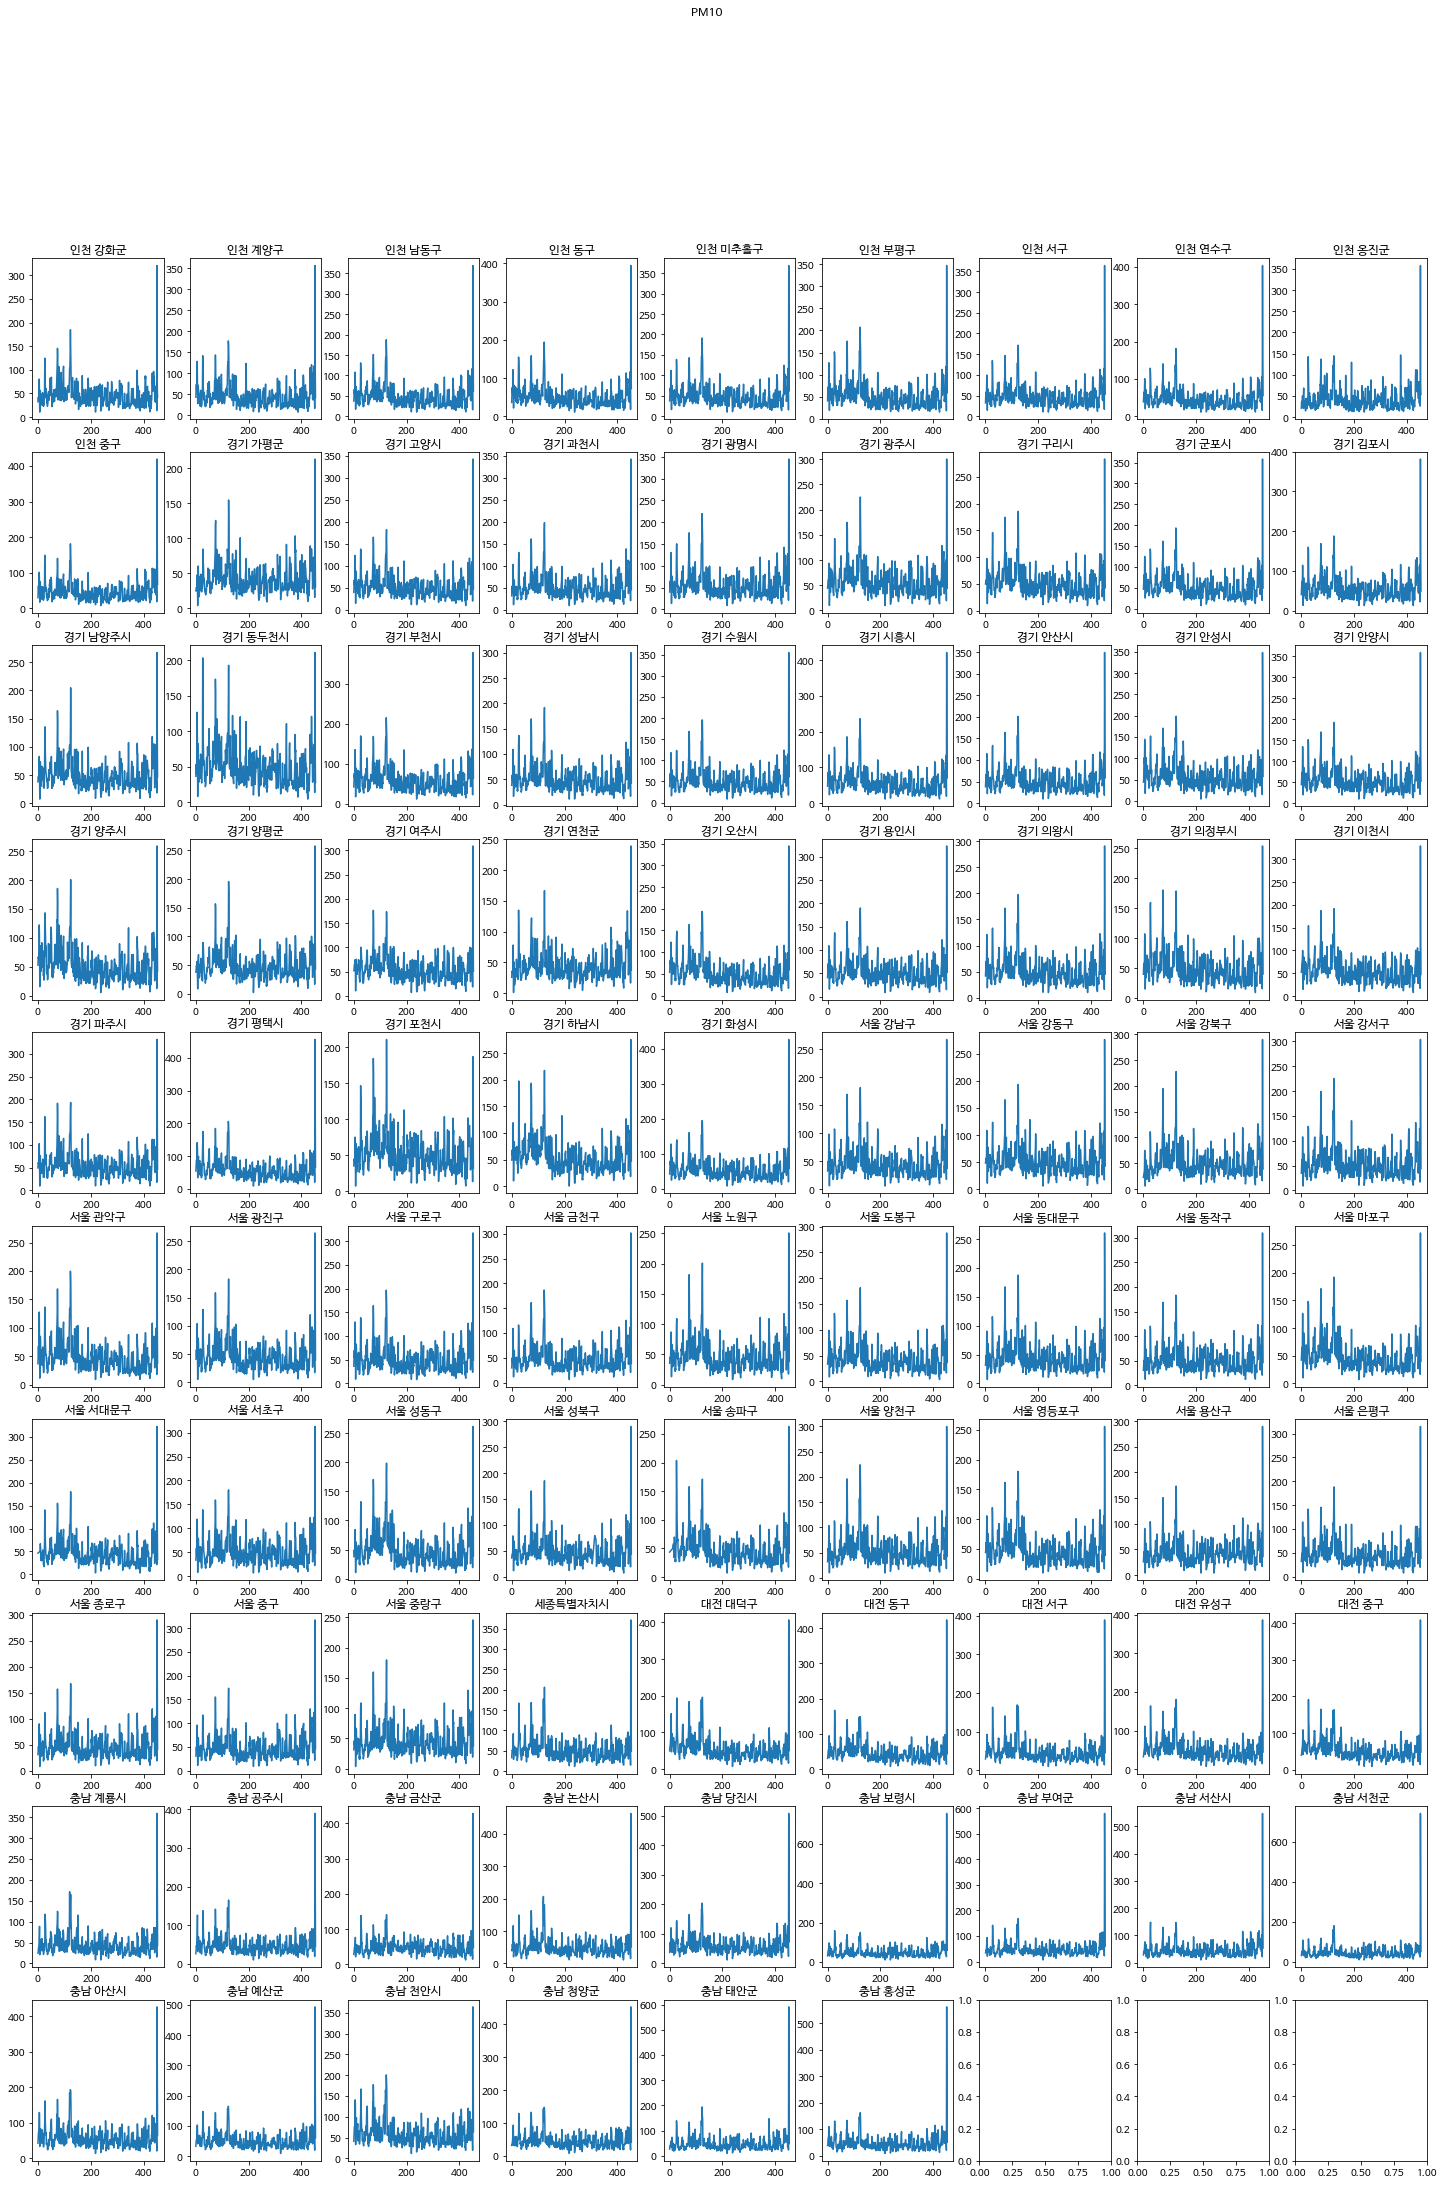

In [200]:
fig, axs = plt.subplots(10,9,figsize=(25,35))
fig.suptitle('PM10')
for i in range(10):
    for j in range(9):
        if i*9+j+1>len(mySeries): 
            continue
        axs[i, j].plot(mySeries[i*9+j].values)
        axs[i, j].set_title(namemySeries[i*9+j])
#plt.show()

#plt.savefig(path+'plot.png',dpi=500)

**정규화**

In [201]:
# MinMaxScaler->StandardScaler
for i in range(len(mySeries)):
    scaler = StandardScaler()
    mySeries[i] = StandardScaler().fit_transform(mySeries[i])
    mySeries[i]= mySeries[i].reshape(len(mySeries[i]))

In [202]:
print("max: "+str(max(mySeries[0]))+"\tmin: "+str(min(mySeries[0])))
print(mySeries[0][:5])

max: 10.700853368798247	min: -1.4269083322261922
[-0.56921983 -0.19624713 -0.21090544 -0.39332004  0.60833154]


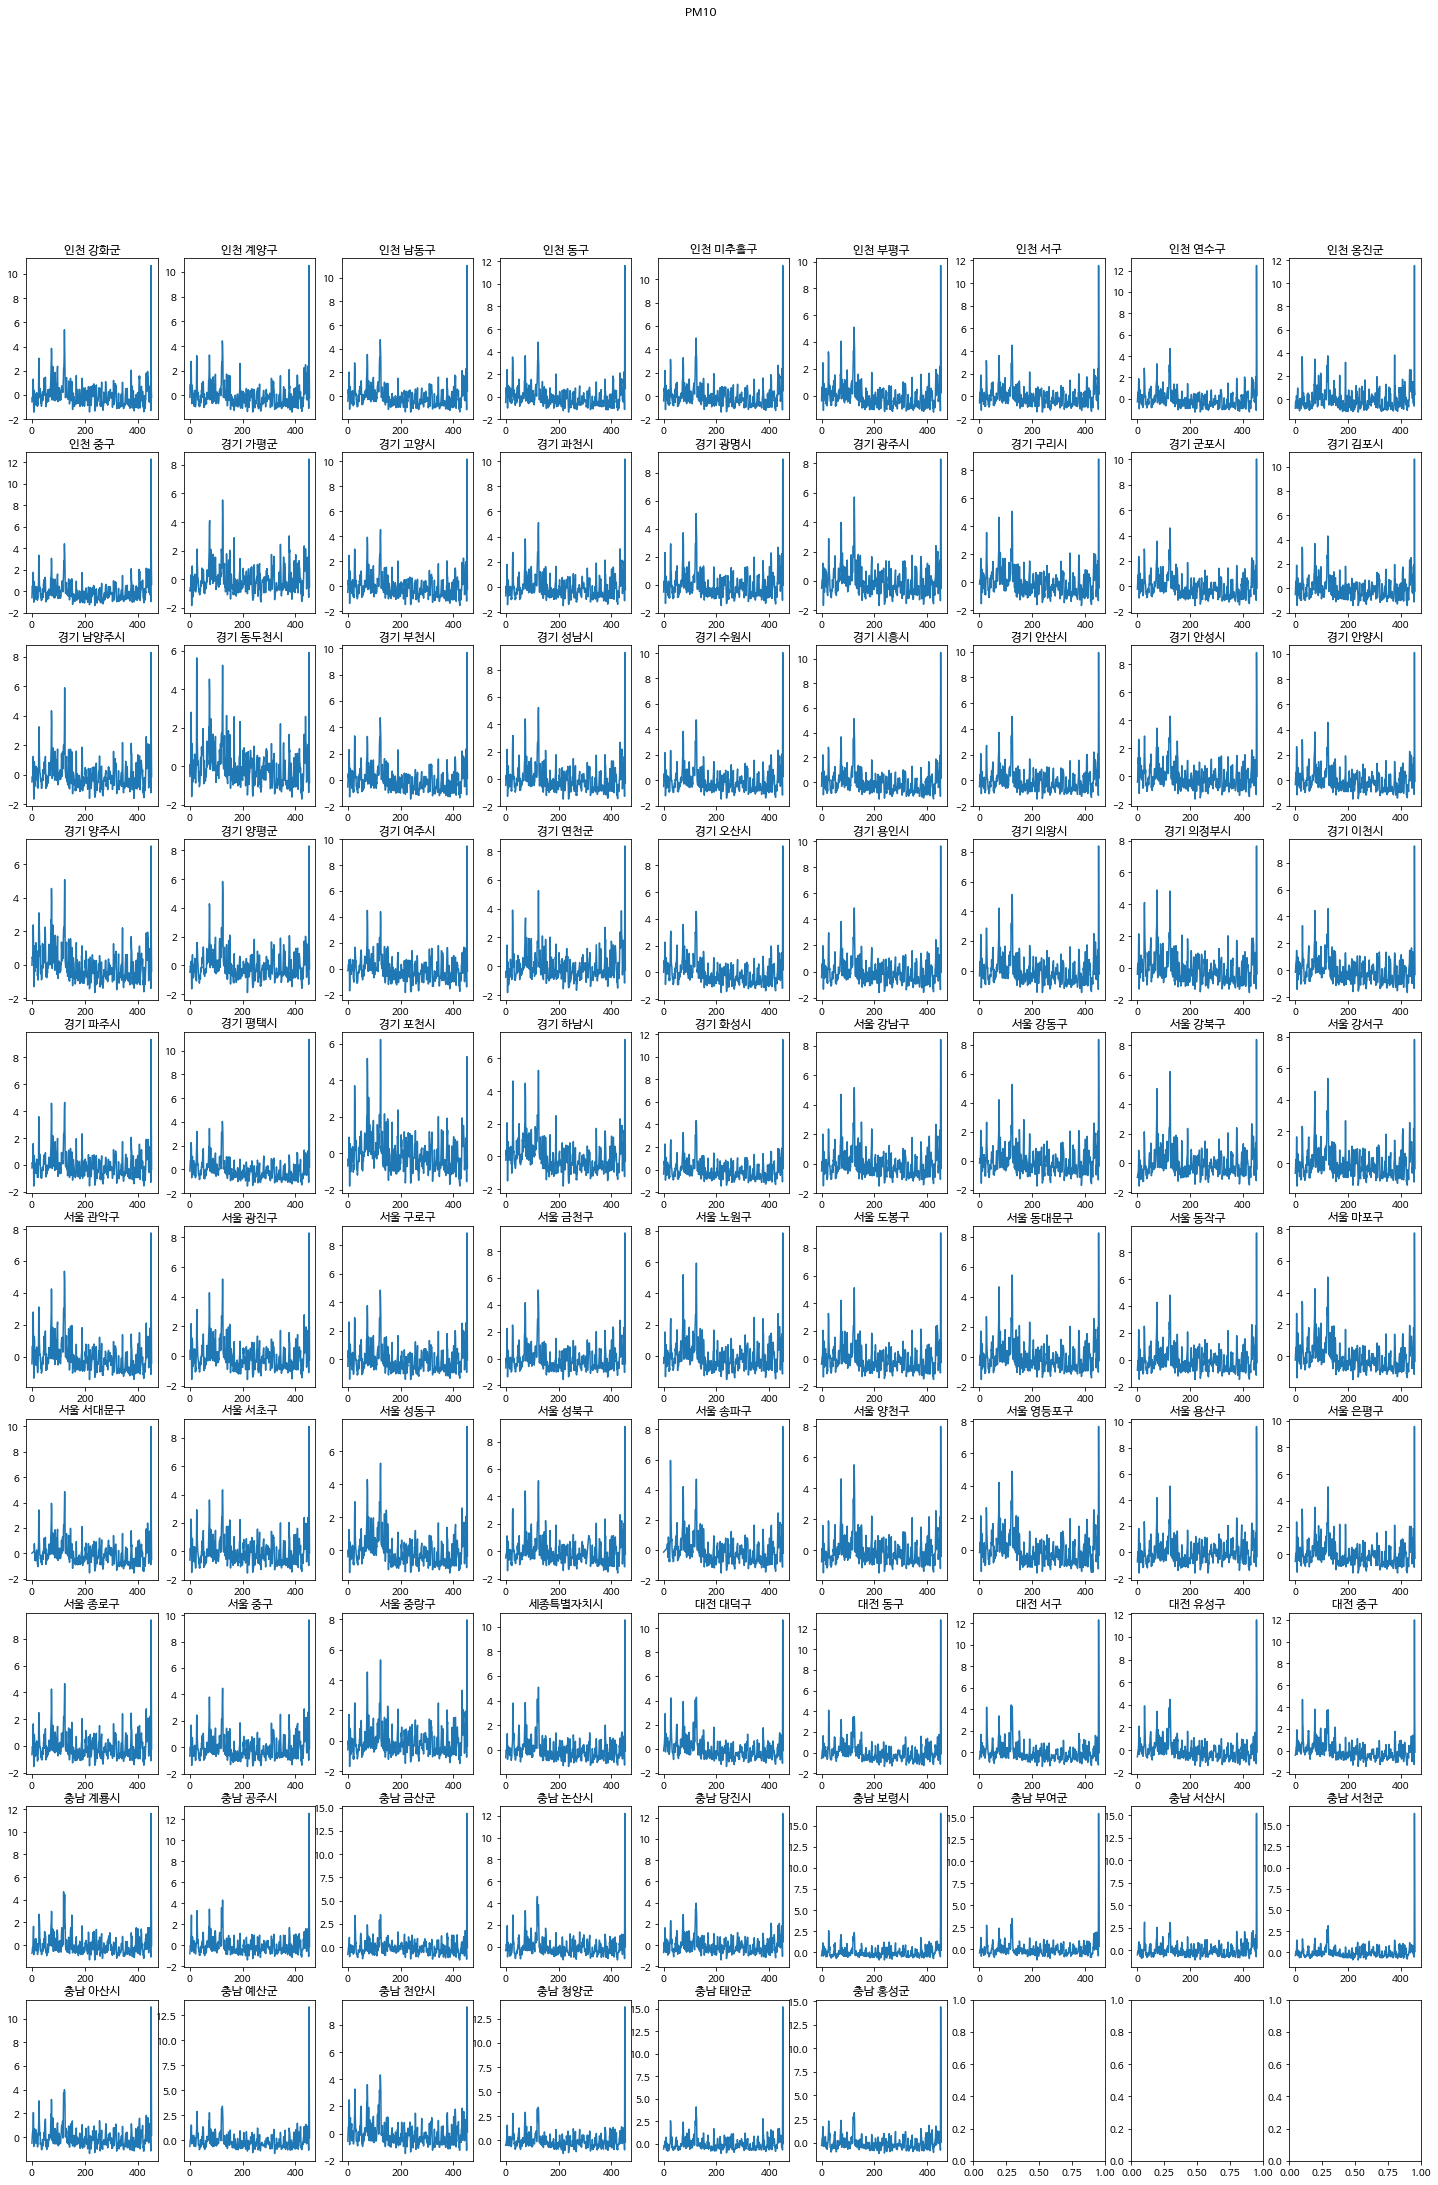

In [203]:
fig, axs = plt.subplots(10,9,figsize=(25,35))
fig.suptitle('PM10')
for i in range(10):
    for j in range(9):
        if i*9+j+1>len(mySeries): 
            continue
        axs[i, j].plot(mySeries[i*9+j])
        axs[i, j].set_title(namemySeries[i*9+j])

# 클러스터링

**클러스터 개수 찾기**

In [124]:
from sklearn.cluster import KMeans
arr = []
k_range = range(2,15)
for k in k_range:
  Kmeans = KMeans(n_clusters=k, random_state = 200)
  Kmeans.fit(mySeries)
  interia = Kmeans.inertia_
  print('k:',k,'inertia:',interia)
  arr.append(interia)
arr = np.array(arr)

k: 2 inertia: 2634.534676527008
k: 3 inertia: 2306.189413478969
k: 4 inertia: 2081.4821327105396
k: 5 inertia: 1920.4071285152377
k: 6 inertia: 1798.6376430166458
k: 7 inertia: 1683.3474892158827
k: 8 inertia: 1600.1380799071749
k: 9 inertia: 1535.721497045748
k: 10 inertia: 1463.3034489220568
k: 11 inertia: 1401.9337071811005
k: 12 inertia: 1322.6543554036746
k: 13 inertia: 1280.2285209279132
k: 14 inertia: 1237.990845680271


Text(0, 0.5, 'Inertia')

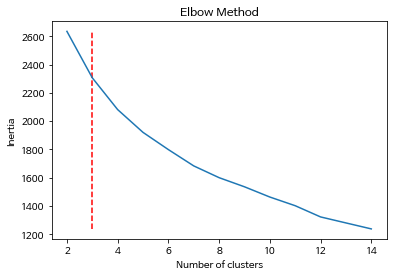

In [125]:
plt.plot(k_range,arr)
plt.vlines(3,ymin=arr.min()*0.9999,ymax=arr.max()*1.0003,linestyles='--',colors='r')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
#plt.show()

#plt.savefig(path+'elbow.png',dpi=200)

**TimeSeriesKMeans를 이용한 클러스터링**

MinMaxScaler를 이용해서 clster_count = 3

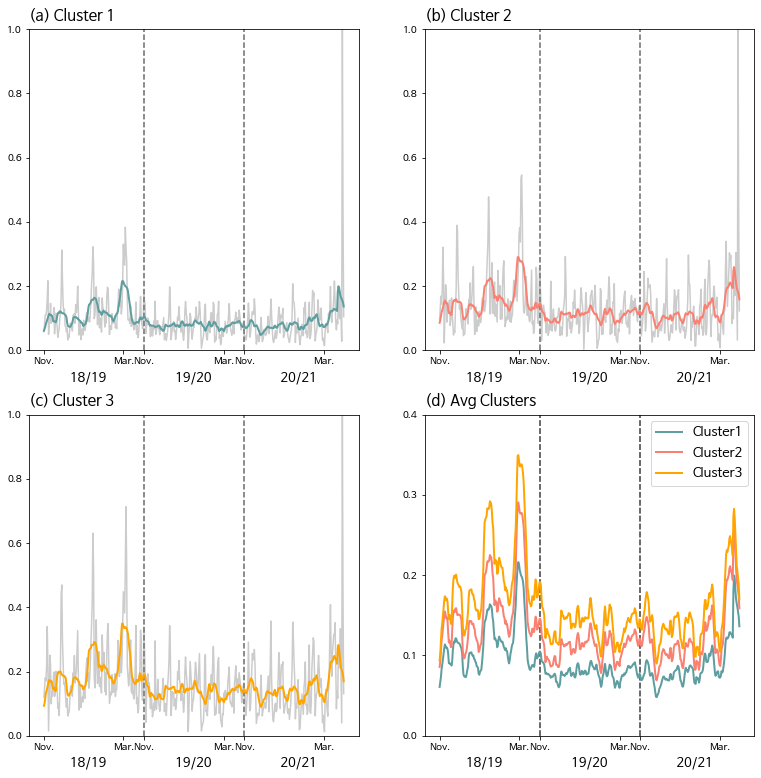

In [149]:
# MinMaxScaler, cluster_count=3
som_y = math.ceil(math.sqrt(math.sqrt(len(mySeries))))
cluster_count = 3
km = TimeSeriesKMeans(random_state=1,n_clusters=cluster_count, metric="dtw",max_iter=150) # n_init=20,
labels = km.fit_predict(mySeries)
averg=[]
# color=['moccasin','darkorange','saddlebrown'] 
color=['cadetblue','salmon','orange']  
apv=['(a)','(b)','(c)','(d)']
plot_count = math.ceil(math.sqrt(cluster_count))

fig, axs = plt.subplots(plot_count,plot_count,figsize=(13,13))
# fig.suptitle('Clusters')
row_i=0
column_j=0
N=15
for label in set(labels):
    cluster = []
    for i in range(len(labels)):
            if(labels[i]==label):
                cluster.append(mySeries[i])
    if len(cluster) > 0:
        yy = dtw_barycenter_averaging(np.vstack(cluster))
        axs[row_i, column_j].plot(yy,c='gray',alpha=0.4)
        axs[row_i, column_j].plot(np.convolve(np.array(yy).flatten(),np.ones(N)/N,mode='same'),c=color[row_i*(som_y-2)+column_j],linewidth=2)
        averg.append(np.convolve(np.array(yy).flatten(),np.ones(N)/N,mode='same'))
        
    axs[row_i, column_j].set_title(apv[row_i*(som_y-2)+column_j]+" Cluster "+str(row_i*(som_y-2)+column_j+1),loc='left',fontsize=15,pad=10)
    axs[row_i, column_j].set_ylim(0,1)
    axs[row_i, column_j].set_xticks(di)
    axs[row_i, column_j].set_xticklabels(['Nov.','Mar.','Nov.','Mar.','Nov.','Mar.'])
    axs[row_i, column_j].set_xlabel('18/19                        19/20                        20/21',fontsize=13)
    axs[row_i, column_j].vlines([len(df1['측정일'].unique()),len(df4['측정일'].unique())],0,1,color="dimgray",linestyles='dashed')
    column_j+=1
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0
    
for s in range(3):
    axs[plot_count-1,plot_count-1].plot(averg[s],c=color[s],label='Cluster'+ str(s+1),linewidth=2)
    axs[plot_count-1,plot_count-1].set_title(apv[-1]+" Avg Clusters",loc='left',fontsize=15,pad=10)
    axs[plot_count-1,plot_count-1].set_ylim(0,0.4)
    axs[plot_count-1,plot_count-1].set_yticks([0,0.1,0.2,0.3,0.4])
    axs[plot_count-1,plot_count-1].legend(fontsize=13)
    axs[plot_count-1,plot_count-1].set_xticks(di)
    axs[plot_count-1,plot_count-1].set_xticklabels(['Nov.','Mar.','Nov.','Mar.','Nov.','Mar.'])
    axs[plot_count-1,plot_count-1].set_xlabel('18/19                        19/20                        20/21',fontsize=13)
    axs[plot_count-1,plot_count-1].vlines([len(df1['측정일'].unique()),len(df4['측정일'].unique())],0,0.4,color="dimgray",linestyles='dashed')
#plt.savefig(path+'cluster plot.png',dpi=200)

StandardScaler를 이용해서 clster_count = 4

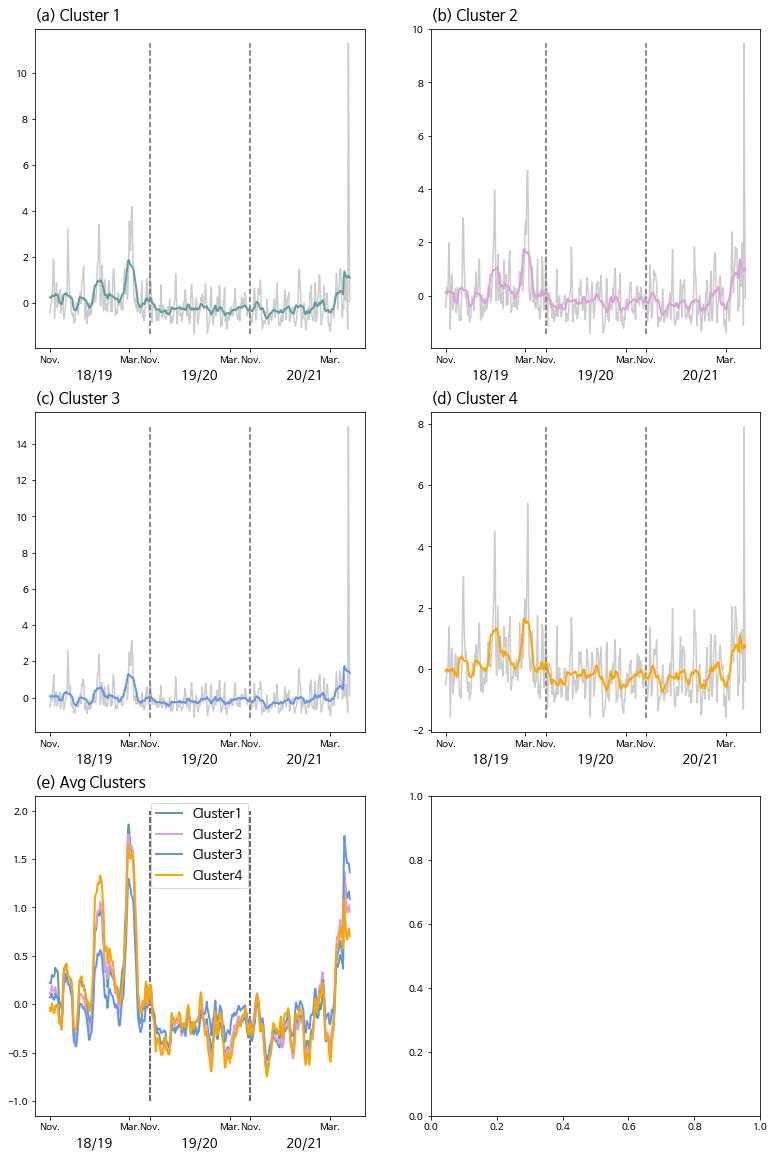

In [204]:
som_y = math.ceil(math.sqrt(math.sqrt(len(mySeries))))
cluster_count = 4
km = TimeSeriesKMeans(random_state=1,n_clusters=cluster_count, metric="dtw",max_iter=150) # n_init=20,
labels = km.fit_predict(mySeries)
averg=[]
# color=['moccasin','darkorange','saddlebrown'] 
color=['cadetblue','plum','cornflowerblue','orange']  
apv=['(a)','(b)','(c)','(d)','(e)']
# plot_count = math.ceil(math.sqrt(cluster_count))

fig, axs = plt.subplots(3,2,figsize=(13,20))
# fig.suptitle('Clusters')
row_i=0
column_j=0
N=15
for label in set(labels):
    cluster = []
    for i in range(len(labels)):
            if(labels[i]==label):
                cluster.append(mySeries[i])
    if len(cluster) > 0:
        yy = dtw_barycenter_averaging(np.vstack(cluster))
        axs[row_i, column_j].plot(yy,c='gray',alpha=0.4)
        axs[row_i, column_j].plot(np.convolve(np.array(yy).flatten(),np.ones(N)/N,mode='same'),c=color[row_i*(som_y-2)+column_j],linewidth=2)
        averg.append(np.convolve(np.array(yy).flatten(),np.ones(N)/N,mode='same'))
        
    axs[row_i, column_j].set_title(apv[row_i*(som_y-2)+column_j]+" Cluster "+str(row_i*(som_y-2)+column_j+1),loc='left',fontsize=15,pad=10)
    axs[row_i, column_j].set_xticks(di)
    axs[row_i, column_j].set_xticklabels(['Nov.','Mar.','Nov.','Mar.','Nov.','Mar.'])
    axs[row_i, column_j].set_xlabel('18/19                        19/20                        20/21',fontsize=13)
    axs[row_i, column_j].vlines([len(df1['측정일'].unique()),len(df4['측정일'].unique())],np.min(yy),np.max(yy),color="dimgray",linestyles='dashed')
    column_j+=1
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0
    
for s in range(4):
    axs[2,0].plot(averg[s],c=color[s],label='Cluster'+ str(s+1),linewidth=2)
    axs[2,0].set_title(apv[-1]+" Avg Clusters",loc='left',fontsize=15,pad=10)
    axs[2,0].legend(fontsize=13)
    axs[2,0].set_xticks(di)
    axs[2,0].set_xticklabels(['Nov.','Mar.','Nov.','Mar.','Nov.','Mar.'])
    axs[2,0].set_xlabel('18/19                        19/20                        20/21',fontsize=13)
    axs[2,0].vlines([len(df1['측정일'].unique()),len(df4['측정일'].unique())],-1,2,color="dimgray",linestyles='dashed')
plt.savefig(path+'cluster plot.png',dpi=200)

In [205]:
labels

array([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 3, 1, 1, 1, 3, 3, 1, 1, 3, 3, 1, 1,
       1, 1, 1, 0, 1, 3, 3, 3, 3, 0, 1, 1, 3, 3, 1, 0, 3, 3, 0, 1, 1, 3,
       1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2])

# 지도 시각화

In [206]:
cluster_map = []

for idx in range(len(mySeries)):
    cluster_map.append((namemySeries[idx],f"Cluster {labels[idx]+1}"))
map = pd.DataFrame(cluster_map,columns=["측정소명","Cluster"]).sort_values(by="Cluster").set_index("측정소명")
map.reset_index(inplace=True)

In [207]:
map.loc[map['측정소명']=='세종특별자치시','측정소명']='세종 세종특별자치시'
map['측정소명'] = map['측정소명'].str[3:]
map

,측정소명,Cluster
0,논산시,Cluster 1
1,대덕구,Cluster 1
2,세종특별자치시,Cluster 1
3,유성구,Cluster 1
4,중구,Cluster 1
...,...,...
82,구리시,Cluster 4
83,광주시,Cluster 4
84,가평군,Cluster 4
85,노원구,Cluster 4


In [208]:
!pip install geopandas
import geopandas as gpd
#import json
#geo = 'SIG6.geojson'
state_geo = gpd.read_file(path+'SIG6.geojson')
#state_geo = json.load(open(geo, encoding='utf-8'))

In [209]:
map_dictionary ={'Cluster 1': 1 , 'Cluster 2' : 2 , 'Cluster 3' : 3 , 'Cluster 4': 4,'Cluster 5': 5,'Cluster 6': 6} 
map['Cluster_n'] = map['Cluster'].map(map_dictionary)
map

,측정소명,Cluster,Cluster_n
0,논산시,Cluster 1,1
1,대덕구,Cluster 1,1
2,세종특별자치시,Cluster 1,1
3,유성구,Cluster 1,1
4,중구,Cluster 1,1
...,...,...,...
82,구리시,Cluster 4,4
83,광주시,Cluster 4,4
84,가평군,Cluster 4,4
85,노원구,Cluster 4,4


In [210]:
m = folium.Map(location=[37.562225,126.978555], tiles="cartodbpositron", zoom_start=8)
m
m.choropleth(
    geo_data = state_geo,
    name='Cluster_n',
    data=map,
    columns=['측정소명', 'Cluster_n'],
    key_on='feature.properties.SIG_KOR_NM',
    fill_color='Set3',
    fill_opacity=0.8,
    line_opacity=0.3,
    color = 'gray',
    legend_name = 'Cluster',
    #threshold_scale = [0,1,2,3,4]
    #bins=[1.1,2.1,3.1,4.1]
)
m

# 20190303-20190307 기간동안의 일별 평균 PM10 분포 확인 



In [61]:
start = dff['측정일'] >= 20190303
end = dff['측정일'] <= 20190307
n_df = dff[start & end]
n_df

,지역,측정일,측정소코드,측정일시,SO2,CO,O3,NO2,PM10,PM25
1522,인천 강화군,20190303,827586.0,2.019030e+09,0.004906,0.870833,0.066688,0.010794,130.937500,78.604167
1523,인천 강화군,20190304,827586.0,2.019030e+09,0.005398,0.965909,0.075773,0.012541,184.590909,117.441860
1524,인천 강화군,20190305,827586.0,2.019031e+09,0.003665,0.973913,0.049391,0.012480,152.333333,96.553191
1525,인천 강화군,20190306,827586.0,2.019031e+09,0.003756,0.887500,0.047021,0.010206,108.145833,73.104167
1526,인천 강화군,20190307,827586.0,2.019031e+09,0.003873,0.602083,0.046542,0.007912,64.250000,36.291667
...,...,...,...,...,...,...,...,...,...,...
188653,충남 홍성군,20190303,534491.5,2.019030e+09,0.005208,0.958333,0.029979,0.027250,133.166667,111.145833
188654,충남 홍성군,20190304,534491.5,2.019030e+09,0.004833,0.916667,0.045125,0.020896,157.437500,120.145833
188655,충남 홍성군,20190305,534491.5,2.019031e+09,0.003771,0.864583,0.043937,0.020521,162.333333,121.833333
188656,충남 홍성군,20190306,534491.5,2.019031e+09,0.003609,0.806522,0.044630,0.018522,133.652174,105.630435


In [71]:
n_df.loc[n_df['지역']=='세종특별자치시','지역']='세종 세종특별자치시'
n_df['지역'] = n_df['지역'].str[3:]
n_df

,지역,측정일,측정소코드,측정일시,SO2,CO,O3,NO2,PM10,PM25
1522,강화군,20190303,827586.0,2.019030e+09,0.004906,0.870833,0.066688,0.010794,130.937500,78.604167
1523,강화군,20190304,827586.0,2.019030e+09,0.005398,0.965909,0.075773,0.012541,184.590909,117.441860
1524,강화군,20190305,827586.0,2.019031e+09,0.003665,0.973913,0.049391,0.012480,152.333333,96.553191
1525,강화군,20190306,827586.0,2.019031e+09,0.003756,0.887500,0.047021,0.010206,108.145833,73.104167
1526,강화군,20190307,827586.0,2.019031e+09,0.003873,0.602083,0.046542,0.007912,64.250000,36.291667
...,...,...,...,...,...,...,...,...,...,...
188653,홍성군,20190303,534491.5,2.019030e+09,0.005208,0.958333,0.029979,0.027250,133.166667,111.145833
188654,홍성군,20190304,534491.5,2.019030e+09,0.004833,0.916667,0.045125,0.020896,157.437500,120.145833
188655,홍성군,20190305,534491.5,2.019031e+09,0.003771,0.864583,0.043937,0.020521,162.333333,121.833333
188656,홍성군,20190306,534491.5,2.019031e+09,0.003609,0.806522,0.044630,0.018522,133.652174,105.630435


In [101]:
m = folium.Map(location=[37.562225,126.978555], tiles="cartodbpositron", zoom_start=8)
m
m.choropleth(
geo_data = state_geo,
name='PM10',
data=n_df[n_df['측정일']==20190303],
columns=['지역', 'PM10'],
key_on='feature.properties.SIG_KOR_NM',
fill_color='Oranges',
fill_opacity=0.8,
line_opacity=0.3,
color = 'gray',
legend_name = 'PM10',
threshold_scale = [0,30,70,110,150,200,250]
)
m

In [213]:
AWS=pd.read_csv(path+'AWS_20190303-0307.csv',encoding='cp949')
AWS

,지점,지점명,일시,풍향(deg),풍속(m/s)
0,12,안면도(감),2019-03-03 01:00,43.2,1.7
1,12,안면도(감),2019-03-03 02:00,31.9,1.6
2,12,안면도(감),2019-03-03 03:00,10.8,2.4
3,12,안면도(감),2019-03-03 04:00,20.5,2.4
4,12,안면도(감),2019-03-03 05:00,52.7,2.6
...,...,...,...,...,...
17180,967,도리도,2019-03-07 20:00,254.2,9.0
17181,967,도리도,2019-03-07 21:00,259.8,8.7
17182,967,도리도,2019-03-07 22:00,279.8,7.6
17183,967,도리도,2019-03-07 23:00,289.9,4.0


In [216]:
AWS['지점명'].unique()

array(['안면도(감)', '관악(레)', '북격렬비도', '용문산', '강남', '서초', '강동', '송파', '강서',
       '양천', '도봉', '노원', '동대문', '중랑', '기상청', '마포', '서대문', '광진', '성북',
       '용산', '은평', '금천', '한강', '중구', '성동', '구로', '강북', '남현', '백령(레)',
       '부천', '안양', '광명', '군포', '김포', '의왕', '남촌', '주교', '송악', '세종고운', '공도',
       '세종금남', '중면', '양도', '대연평', '교동', '도라산', '포천', '가평조종', '파주금촌', '창수',
       '왕산', '관악', '영등포 ', '공촌동', '인천연수', '덕적도', '대부도', '운평', '안성',
       '가평북면', '의정부', '백사', '장호원', '신서', '포천이동', '고양', '남양주', '청평', '영종도',
       '전곡항', '안산', '경기광주', '양동', '여주', '용인', '오산', '평택', '시흥', '적성',
       '일동', '구리', '금곡', '화성', '성남', '청운', '대신', '용인이동', '백암', '장봉도',
       '호도', '능곡', '과천', '양주', '광릉', '대산', '근흥', '홍북', '삽시도', '홍성죽도',
       '세종연서', '공주', '서천', '논산', '당진', '성거', '청양', '태안', '예산', '세종전의',
       '송도', '유구', '정안', '아산', '양화', '계룡', '신평', '오월드', '세천', '연무', '서부',
       '춘장대', '장동', '부평', '연천청산', '자월도', '소청도', '볼음도', '대천항', '만리포',
       '계룡산', '승봉도', '목덕도', '영흥도', '무의도', '안도', '옹도', '외연도', '정산', '백학'

In [217]:
n_df['지역'].unique()

array(['강화군', '계양구', '남동구', '동구', '미추홀구', '부평구', '서구', '연수구', '옹진군', '중구',
       '가평군', '고양시', '과천시', '광명시', '광주시', '구리시', '군포시', '김포시', '남양주시',
       '동두천시', '부천시', '성남시', '수원시', '시흥시', '안산시', '안성시', '안양시', '양주시',
       '양평군', '여주시', '연천군', '오산시', '용인시', '의왕시', '의정부시', '이천시', '파주시',
       '평택시', '포천시', '하남시', '화성시', '강남구', '강동구', '강북구', '강서구', '관악구',
       '광진구', '구로구', '금천구', '노원구', '도봉구', '동대문구', '동작구', '마포구', '서대문구',
       '서초구', '성동구', '성북구', '송파구', '양천구', '영등포구', '용산구', '은평구', '종로구',
       '중랑구', '세종특별자치시', '대덕구', '유성구', '계룡시', '공주시', '금산군', '논산시', '당진시',
       '보령시', '부여군', '서산시', '서천군', '아산시', '예산군', '천안시', '청양군', '태안군',
       '홍성군'], dtype=object)